## Initiate the spark session and load the data

In [7]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Taxi_Fare_Prediction").getOrCreate()


In [8]:
# Load the data 
data = spark.read.csv("/Volumes/Jagannath/Fall 2024/Cloud Computing/Assignment_3/nyc_taxi.csv", header = True, inferSchema = True)
data.show(10)
data.printSchema

+-----------+-------------------+------------+-------------------+--------+----+-----+
|pickup_date|        pickup_time|dropoff_date|       dropoff_time|distance| tip| fare|
+-----------+-------------------+------------+-------------------+--------+----+-----+
|   1/1/2017|2024-10-23 00:00:00|    1/1/2017|2024-10-23 00:00:00|    0.02| 0.0| 52.8|
|   1/1/2017|2024-10-23 00:00:00|    1/1/2017|2024-10-23 00:03:00|     0.5| 0.0|  5.3|
|   1/1/2017|2024-10-23 00:00:00|    1/1/2017|2024-10-23 00:39:00|    7.75|4.66|27.96|
|   1/1/2017|2024-10-23 00:00:00|    1/1/2017|2024-10-23 00:06:00|     0.8|1.45| 8.75|
|   1/1/2017|2024-10-23 00:00:00|    1/1/2017|2024-10-23 00:08:00|     0.9| 0.0|  8.3|
|   1/1/2017|2024-10-23 00:00:00|    1/1/2017|2024-10-23 00:05:00|    1.76| 0.0|  8.3|
|   1/1/2017|2024-10-23 00:00:00|    1/1/2017|2024-10-23 00:15:00|    8.47|7.71|38.55|
|   1/1/2017|2024-10-23 00:00:00|    1/1/2017|2024-10-23 00:11:00|     2.4| 0.0| 11.8|
|   1/1/2017|2024-10-23 00:00:00|    1/1/20

<bound method DataFrame.printSchema of DataFrame[pickup_date: string, pickup_time: timestamp, dropoff_date: string, dropoff_time: timestamp, distance: double, tip: double, fare: double]>

## Data exploration and pre-processing 

In [9]:
# Handling missing values 
data = data.dropna(subset = ['distance', 'fare']) # These are the relevent data columns
data.show(5)

+-----------+-------------------+------------+-------------------+--------+----+-----+
|pickup_date|        pickup_time|dropoff_date|       dropoff_time|distance| tip| fare|
+-----------+-------------------+------------+-------------------+--------+----+-----+
|   1/1/2017|2024-10-23 00:00:00|    1/1/2017|2024-10-23 00:00:00|    0.02| 0.0| 52.8|
|   1/1/2017|2024-10-23 00:00:00|    1/1/2017|2024-10-23 00:03:00|     0.5| 0.0|  5.3|
|   1/1/2017|2024-10-23 00:00:00|    1/1/2017|2024-10-23 00:39:00|    7.75|4.66|27.96|
|   1/1/2017|2024-10-23 00:00:00|    1/1/2017|2024-10-23 00:06:00|     0.8|1.45| 8.75|
|   1/1/2017|2024-10-23 00:00:00|    1/1/2017|2024-10-23 00:08:00|     0.9| 0.0|  8.3|
+-----------+-------------------+------------+-------------------+--------+----+-----+
only showing top 5 rows



In [10]:
# Check the data types 
print(data.dtypes)

[('pickup_date', 'string'), ('pickup_time', 'timestamp'), ('dropoff_date', 'string'), ('dropoff_time', 'timestamp'), ('distance', 'double'), ('tip', 'double'), ('fare', 'double')]


In [15]:
from pyspark.sql.functions import col, concat, lit, to_timestamp
from pyspark.ml.feature import VectorAssembler

# Cast distance and fare to float
data = data.withColumn("distance", col("distance").cast("float"))
data = data.withColumn("fare", col("fare").cast("float"))

print(data.dtypes)

[('pickup_date', 'string'), ('pickup_time', 'timestamp'), ('dropoff_date', 'string'), ('dropoff_time', 'timestamp'), ('distance', 'float'), ('tip', 'double'), ('fare', 'float'), ('pickup_datetime', 'timestamp'), ('dropoff_datetime', 'timestamp')]


In [16]:
# Combine date and time into proper timestamp format
data = data.withColumn("pickup_datetime", 
                       to_timestamp(concat(col("pickup_date"), lit(" "), col("pickup_time").substr(12, 8)), "M/d/yyyy HH:mm:ss"))

data = data.withColumn("dropoff_datetime", 
                       to_timestamp(concat(col("dropoff_date"), lit(" "), col("dropoff_time").substr(12, 8)), "M/d/yyyy HH:mm:ss"))

In [17]:
data.show(5)

+-----------+-------------------+------------+-------------------+--------+----+-----+-------------------+-------------------+
|pickup_date|        pickup_time|dropoff_date|       dropoff_time|distance| tip| fare|    pickup_datetime|   dropoff_datetime|
+-----------+-------------------+------------+-------------------+--------+----+-----+-------------------+-------------------+
|   1/1/2017|2024-10-23 00:00:00|    1/1/2017|2024-10-23 00:00:00|    0.02| 0.0| 52.8|2017-01-01 00:00:00|2017-01-01 00:00:00|
|   1/1/2017|2024-10-23 00:00:00|    1/1/2017|2024-10-23 00:03:00|     0.5| 0.0|  5.3|2017-01-01 00:00:00|2017-01-01 00:03:00|
|   1/1/2017|2024-10-23 00:00:00|    1/1/2017|2024-10-23 00:39:00|    7.75|4.66|27.96|2017-01-01 00:00:00|2017-01-01 00:39:00|
|   1/1/2017|2024-10-23 00:00:00|    1/1/2017|2024-10-23 00:06:00|     0.8|1.45| 8.75|2017-01-01 00:00:00|2017-01-01 00:06:00|
|   1/1/2017|2024-10-23 00:00:00|    1/1/2017|2024-10-23 00:08:00|     0.9| 0.0|  8.3|2017-01-01 00:00:00|2017-

In [18]:

# Calculate trip duration in minutes
data = data.withColumn("trip_duration", 
                       (col("dropoff_datetime").cast("long") - col("pickup_datetime").cast("long")) / 60)

In [19]:
data.show(10)

+-----------+-------------------+------------+-------------------+--------+----+-----+-------------------+-------------------+-------------+
|pickup_date|        pickup_time|dropoff_date|       dropoff_time|distance| tip| fare|    pickup_datetime|   dropoff_datetime|trip_duration|
+-----------+-------------------+------------+-------------------+--------+----+-----+-------------------+-------------------+-------------+
|   1/1/2017|2024-10-23 00:00:00|    1/1/2017|2024-10-23 00:00:00|    0.02| 0.0| 52.8|2017-01-01 00:00:00|2017-01-01 00:00:00|          0.0|
|   1/1/2017|2024-10-23 00:00:00|    1/1/2017|2024-10-23 00:03:00|     0.5| 0.0|  5.3|2017-01-01 00:00:00|2017-01-01 00:03:00|          3.0|
|   1/1/2017|2024-10-23 00:00:00|    1/1/2017|2024-10-23 00:39:00|    7.75|4.66|27.96|2017-01-01 00:00:00|2017-01-01 00:39:00|         39.0|
|   1/1/2017|2024-10-23 00:00:00|    1/1/2017|2024-10-23 00:06:00|     0.8|1.45| 8.75|2017-01-01 00:00:00|2017-01-01 00:06:00|          6.0|
|   1/1/2017|

##  Develope the model 1 to predict taxi fare from trip distance

For Model M1: We are using only trip distance to predict the fare.

In [20]:
# Prepare the data 
assembler_m1 = VectorAssembler(inputCols=["distance"], outputCol="features") # Create a VectorAssembler to combine 'distance' and 'trip_duration' into a single feature vector
data_m1 = assembler_m1.transform(data).select("features", "fare") # Transform the original data using the assembler

In [33]:
# Fit the modle
from pyspark.ml.regression import LinearRegression # Import regression model
lr_model1 = LinearRegression(featuresCol="features", labelCol="fare")
model_m1 = lr_model1.fit(data_m1)

24/10/23 21:49:07 WARN Instrumentation: [f33be381] regParam is zero, which might cause numerical instability and overfitting.


## What is the fare of a 20 mile long trip using M1

In [24]:
test_data_m1 = spark.createDataFrame([(20,)], ["distance"])
test_data_m1 = assembler_m1.transform(test_data_m1)
prediction_m1 = model_m1.transform(test_data_m1)
fare_20_mile = prediction_m1.collect()[0].prediction

print(f"Fare of a 20 mile long trip would be: ${fare_20_mile:.2f}")

Fare of a 20 mile long trip would be: $69.98


## Develope the model 2

In [25]:
# Prepare the data 
assembler_m2 = VectorAssembler(inputCols=["distance", "trip_duration"], outputCol="features") # Create a VectorAssembler to combine 'distance' and 'trip_duration' into a single feature vector
data_m2 = assembler_m2.transform(data).select("features", "fare") # Transform the original data using the assembler

In [27]:
# Fit the model 
lr_model2 = LinearRegression(featuresCol="features", labelCol="fare")
model_model2 = lr_m2.fit(data_m2)

24/10/23 21:48:16 WARN Instrumentation: [ddf4b8aa] regParam is zero, which might cause numerical instability and overfitting.


# What is the fare of a 14 mile trip that took 75 minutes using M2

In [28]:
test_data_m2 = spark.createDataFrame([(14, 75)], ["distance", "trip_duration"]) # SO we have the distnace and travel duration
test_data_m2 = assembler_m2.transform(test_data_m2) # Combines multiple feature columns into a single vector column named
prediction_m2_14_75 = model_m2.transform(test_data_m2)
fare_of_trip_14_75 = prediction_m2_14_75.collect()[0].prediction

print(f"The predicted fare for a 14-mile trip that took 75 minutes using Model M2 is: ${fare_of_trip_14_75:.2f}")

The predicted fare for a 14-mile trip that took 75 minutes using Model M2 is: $51.27


In [29]:
test_data_compare = spark.createDataFrame([(10, 40), (13, 25)], ["distance", "trip_duration"])
test_data_compare = assembler_m2.transform(test_data_compare)
predictions_compare = model_m2.transform(test_data_compare).collect()
# the predicted fares for the two trips and sets higher_fare_trip to the one with the higher fare. 
# If the fare for the 10-mile, 40-minute trip is higher, it picks 10 mile trip taking 40 min; otherwise, it picks 13 mile trip taking 25 min
higher_fare_trip = "10 mile trip taking 40 min" if predictions_compare[0].prediction > predictions_compare[1].prediction else "13 mile trip taking 25 min"
print(f"The trip with the higher predicted fare is: {higher_fare_trip}")

The trip with the higher predicted fare is: 13 mile trip taking 25 min


## Compute average tip amount 

In [30]:
average_tip = data.selectExpr("avg(tip)").collect()[0][0]
print(f"Average tip amount: ${average_tip:.2f}")

Average tip amount: $1.70


## Determine Busiest Hour

In [31]:
# Group the data by hour
# This means we are organizing all the taxi trips based on the hour they started.

busiest_hour_data = data.withColumn("hour", data.pickup_time.substr(0, 2).cast("int"))

# Count how many trips happened in each hour
# Here, we are counting the number of trips for each group (each hour).
# Get the first row from our sorted list, which is the hour with the most trips
# The first row in this sorted list will have the highest count of trips.
busiest_hour = busiest_hour_data.groupBy("hour").count().orderBy("count", ascending=False).first()[0]


# Print out the busiest hour
print(f"The busiest hour for taxi rides is: {busiest_hour}:00")

The busiest hour for taxi rides is: 20:00


## Compare Spark’s performance
Divide the data into 10 parts: 10%, 20%, …, 100%
Plot the time taken by each method and save in PNG format (or just display the plot if you are using jupyter notebook or Google Colab)

24/10/23 21:49:12 WARN Instrumentation: [56e8fe7d] regParam is zero, which might cause numerical instability and overfitting.
24/10/23 21:49:13 WARN Instrumentation: [f2104c28] regParam is zero, which might cause numerical instability and overfitting.
24/10/23 21:49:15 WARN Instrumentation: [7fff0a90] regParam is zero, which might cause numerical instability and overfitting.
24/10/23 21:49:16 WARN Instrumentation: [a7a4446c] regParam is zero, which might cause numerical instability and overfitting.
24/10/23 21:49:18 WARN Instrumentation: [3fd7d080] regParam is zero, which might cause numerical instability and overfitting.
24/10/23 21:49:19 WARN Instrumentation: [31d60ee3] regParam is zero, which might cause numerical instability and overfitting.
24/10/23 21:49:21 WARN Instrumentation: [f842db81] regParam is zero, which might cause numerical instability and overfitting.
24/10/23 21:49:22 WARN Instrumentation: [71ccbc28] regParam is zero, which might cause numerical instability and overf

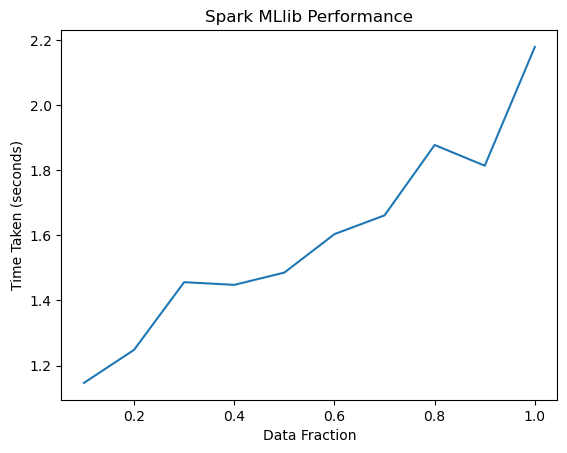

In [34]:
import time # import the time module 
import matplotlib.pyplot as plt # Import library
percentages = [i/10 for i in range(1, 11)] # # Create a list of percentages from 0.1 to 1.0, representing 10% to 100% of the data
times_taken = [] # Create an empty list to store

for p in percentages: # Loop through each percentage in the list
    start_time = time.time() # Record the start time before processing begins
    sample_df = data.sample(fraction=p)  # Transform the sampled data to prepare it for model training
    sample_data = assembler_m2.transform(sample_df).select("features", "fare") 
    lr_sample_model = lr_m2.fit(sample_data) # Train a linear regression model on the sampled data
    times_taken.append(time.time() - start_time) # Calculate and store the time taken for this iteration by subtracting start_time from current time

plt.plot(percentages, times_taken)
plt.xlabel('Data Fraction')
plt.ylabel('Time Taken (seconds)')
plt.title('Spark MLlib Performance')
plt.show()

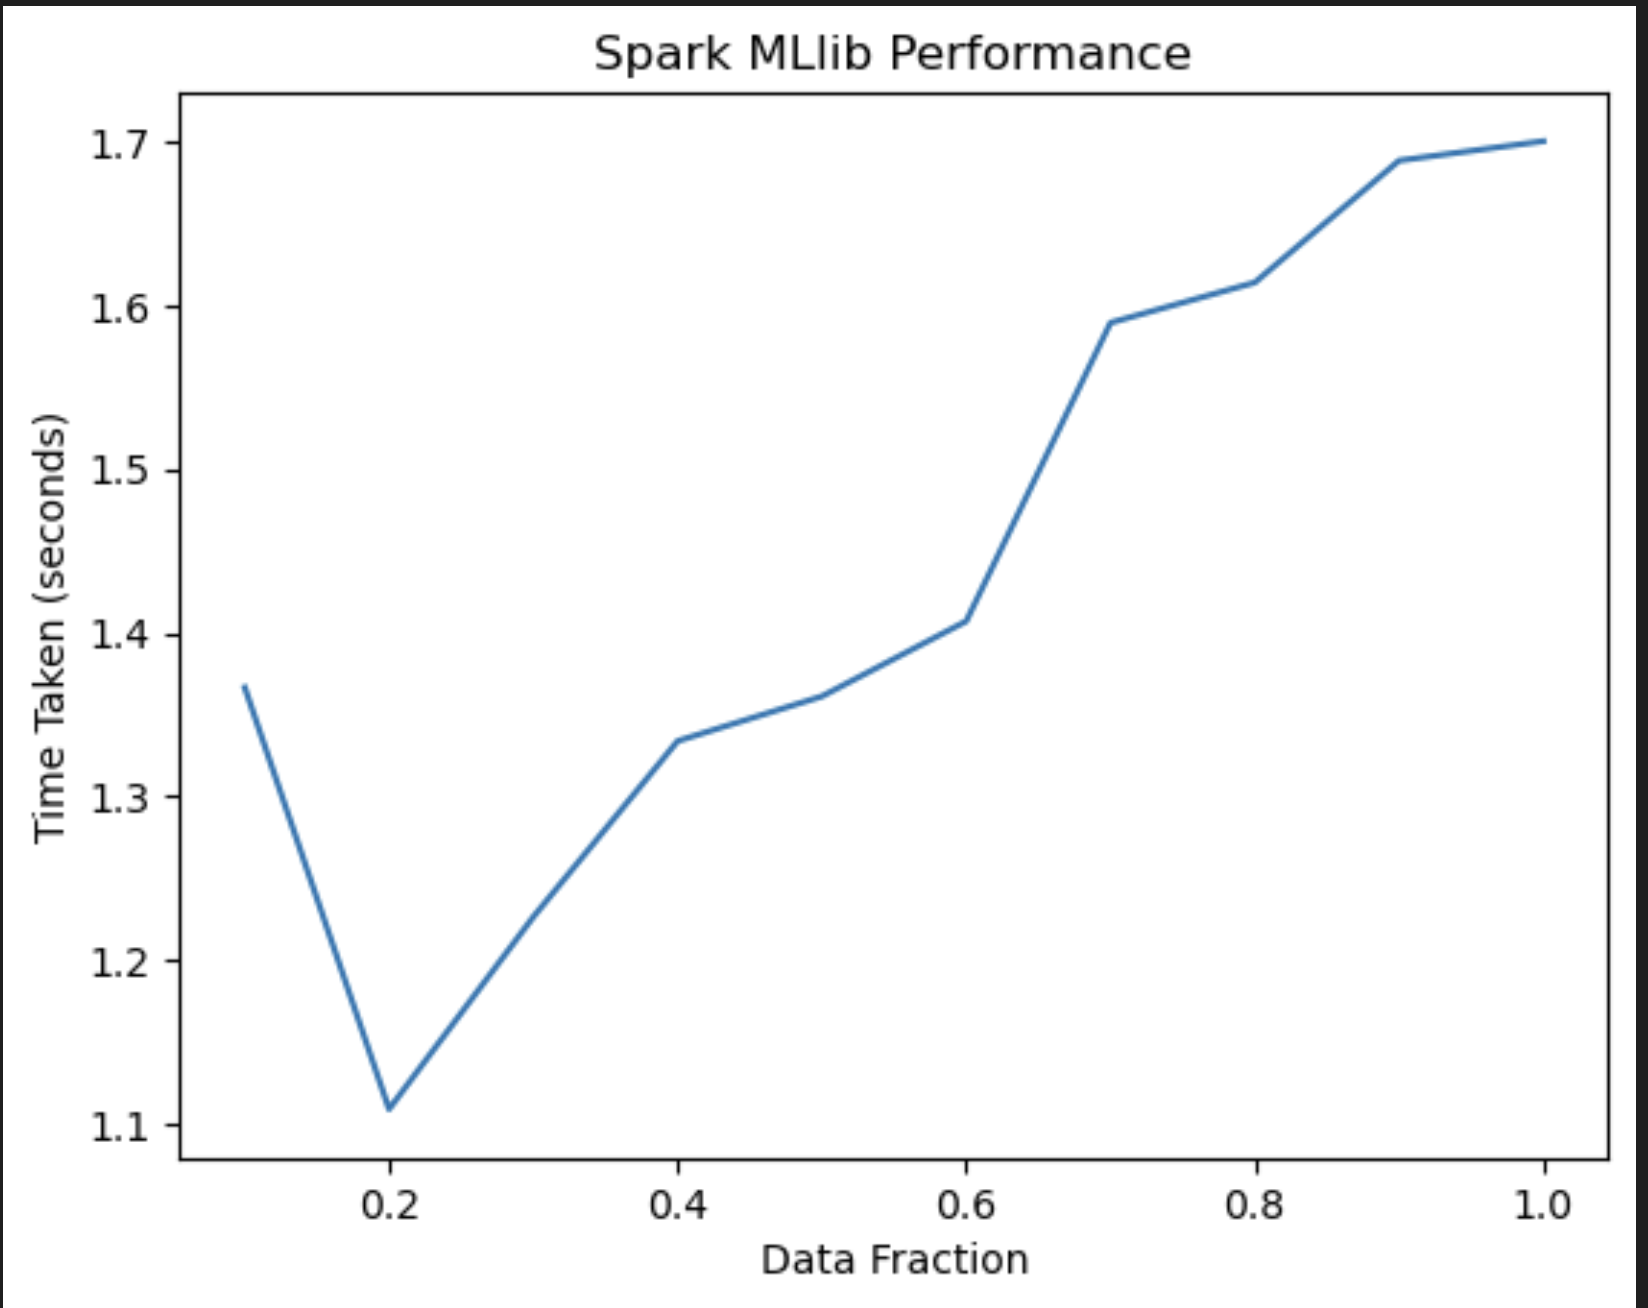